In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_excel("../Clean_data/Dates_all.xlsx")

# Nettoyage : exclure les lignes avec Type == Global
df = df[df['Source'] != 'Global']
# Agréger les clics et impressions par date
df_grouped = df.groupby("Date", as_index=False)[["Clics", "Impressions"]].sum()

# Trier par date
df_grouped = df_grouped.sort_values("Date")
print(df.head())

        Date  Clics  Impressions     CTR  Position            Source
0 2025-02-05    533        35706  0.0149     15.07  manufacturer URL
1 2025-02-04    663        37186  0.0178     15.17  manufacturer URL
2 2025-02-03    588        39173  0.0150     14.97  manufacturer URL
3 2025-02-02    506        42130  0.0120     18.14  manufacturer URL
4 2025-02-01    558        42176  0.0132     17.53  manufacturer URL


In [53]:
# Configuration de style
sns.set_theme(style="whitegrid")

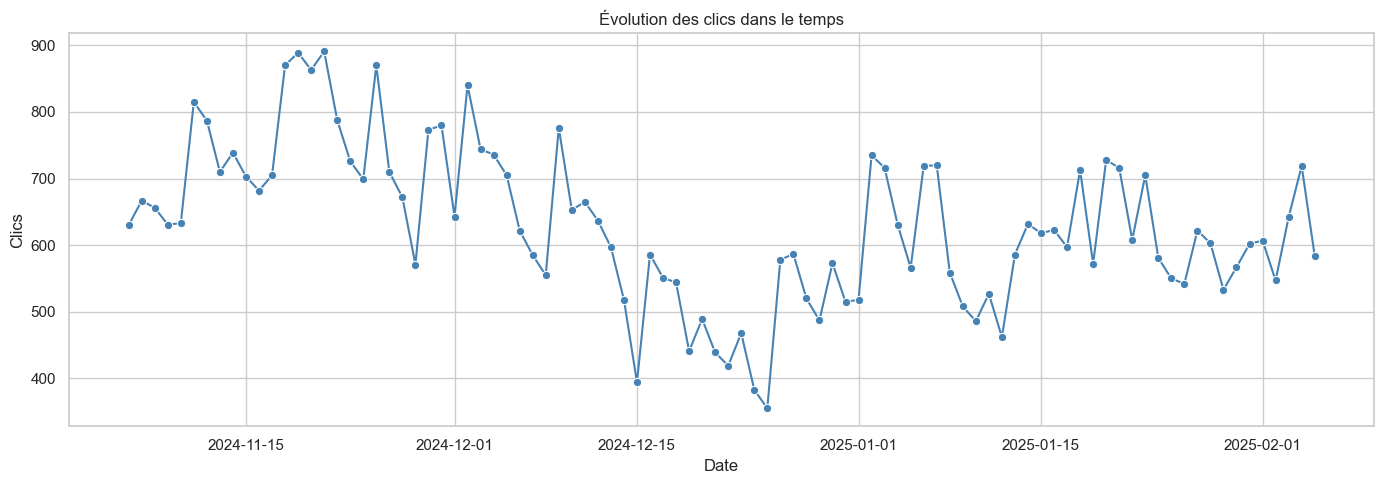

In [54]:
# Courbe des clics dans le temps

plt.figure(figsize=(14, 5))
sns.lineplot(data=df_grouped, x="Date", y="Clics", marker="o", color="steelblue")
plt.title("Évolution des clics dans le temps")
plt.xlabel("Date")
plt.ylabel("Clics")
plt.tight_layout()
plt.savefig('../assets/clics_through_time.png', dpi=300, bbox_inches='tight')
plt.show()

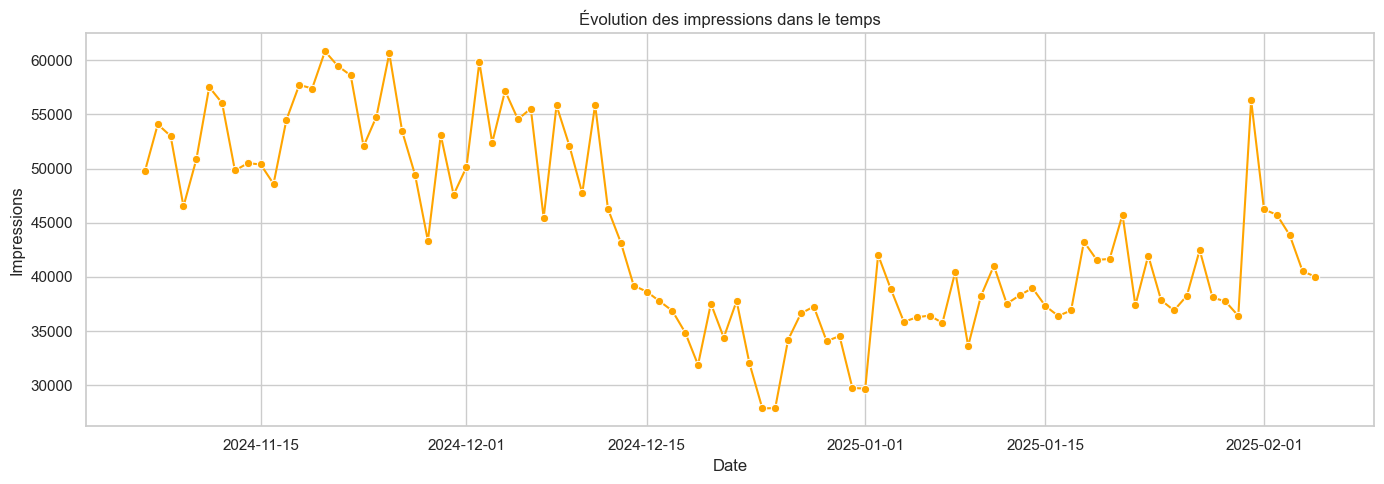

In [55]:
# Courbe des impressions dans le temps
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_grouped, x="Date", y="Impressions", marker="o", color="orange")
plt.title("Évolution des impressions dans le temps")
plt.xlabel("Date")
plt.ylabel("Impressions")
plt.tight_layout()
plt.savefig('../assets/impressions_through_time.png', dpi=300, bbox_inches='tight')
plt.show()

## CTR (Click-Through Rate) : 
reflète l'engagement → % des gens qui cliquent quand la page apparaît.

## Position moyenne : 
reflète la visibilité dans Google → plus la valeur est basse, mieux c'est (1 = top 1, 10 = bas de première page…).


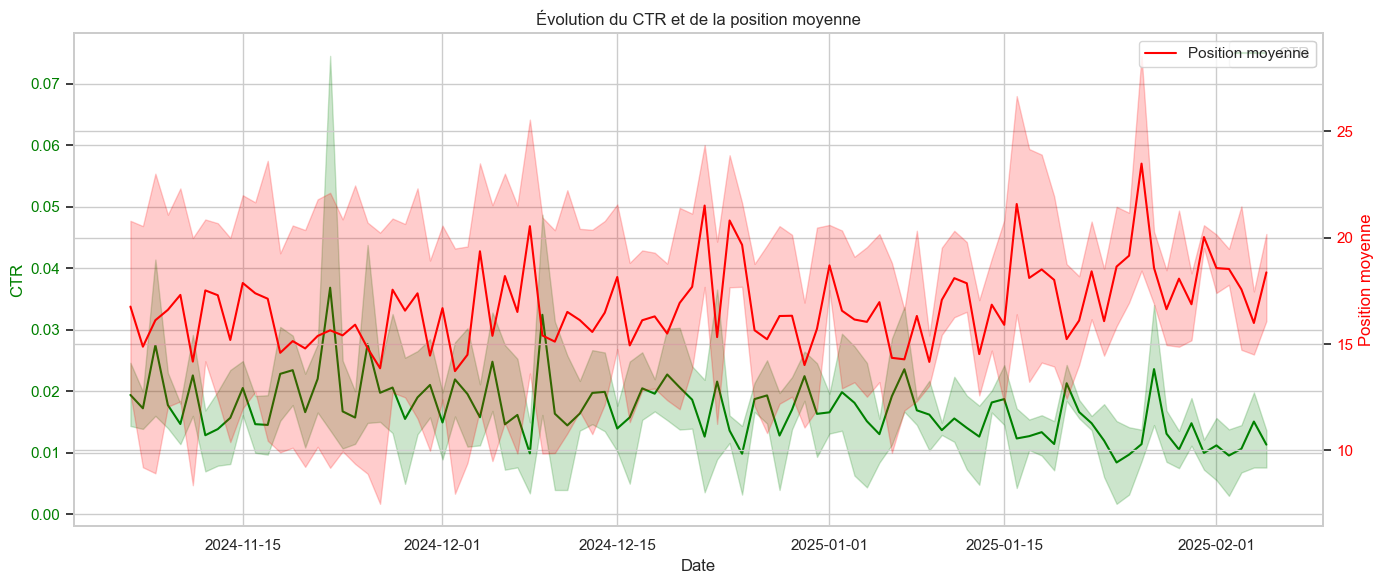

In [56]:
# Courbe du CTR et Position moyenne dans le temps
fig, ax1 = plt.subplots(figsize=(14, 6))

sns.lineplot(data=df, x="Date", y="CTR", ax=ax1, label="CTR", color="green")
ax1.set_ylabel("CTR", color="green")
ax1.tick_params(axis='y', labelcolor="green")

ax2 = ax1.twinx()
sns.lineplot(data=df, x="Date", y="Position", ax=ax2, label="Position moyenne", color="red")
ax2.set_ylabel("Position moyenne", color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.title("Évolution du CTR et de la position moyenne")
plt.tight_layout()
plt.savefig('../assets/ctr_pos_moyenne_in_time.png', dpi=300, bbox_inches='tight')
plt.show()

### Relation → souvent, plus la position est haute (ex : position 1 à 5), plus le CTR est bon

<Figure size 1400x600 with 0 Axes>

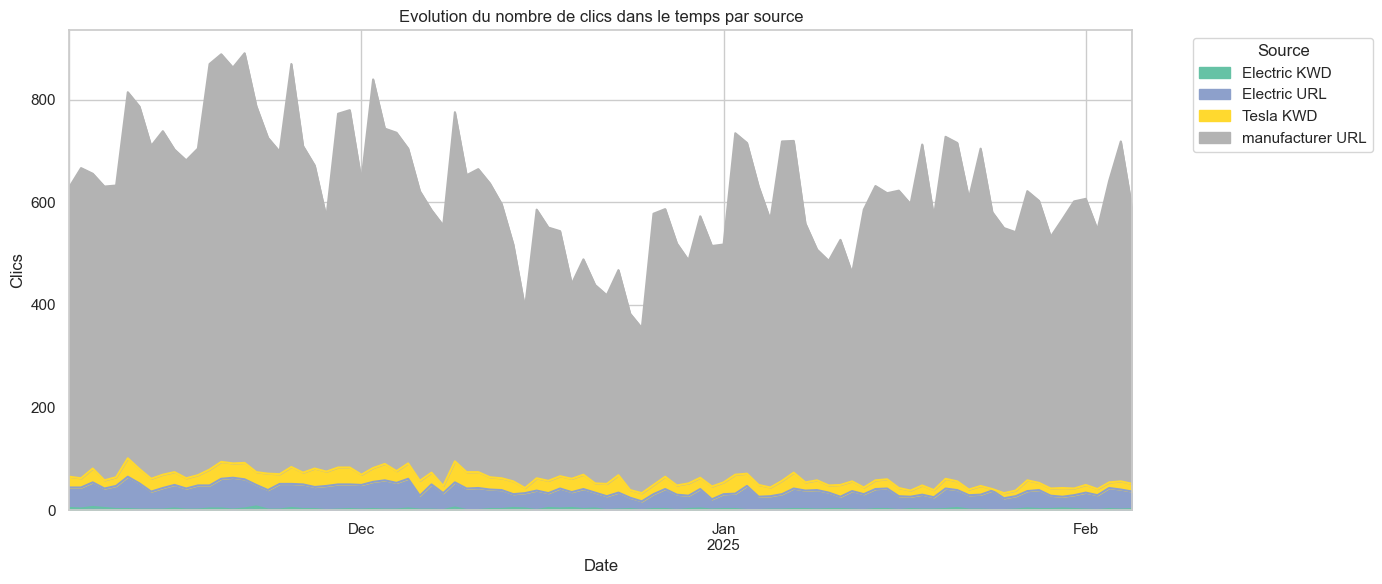

In [57]:
# évolution cumulée des clics par Source dans le temps
# Grouper par Date et Source
df_grouped = df.groupby(['Date', 'Source'])['Clics'].sum().reset_index()

# Réorganiser les données pour area plot
df_pivot = df_grouped.pivot(index='Date', columns='Source', values='Clics').fillna(0)

# Trier les dates
df_pivot = df_pivot.sort_index()

# Plot : aires empilées
plt.figure(figsize=(14, 6))
df_pivot.plot(kind='area', stacked=True, figsize=(14, 6), colormap='Set2')

plt.title("Evolution du nombre de clics dans le temps par source")
plt.xlabel("Date")
plt.ylabel("Clics")
plt.legend(title="Source", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../assets/clics_evolution_over_time_by_source.png', dpi=300, bbox_inches='tight')

plt.show()

Question : Quelle source a généré le plus de clics ? Quand est-ce qu'une nouvelle source est devenue dominante ?

In [49]:
# More analysis to be dnoe